In [ ]:
import numpy as np
import cv2
from scipy.constants import c, pi
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm
from scipy.ndimage import gaussian_filter1d
from matplotlib.patches import Rectangle
from tqdm import tqdm

# uncomment for inline matlab style interactive figures
# %matplotlib widget

%cd "../"
import simulation as sim
import fft_shift as fft_shift
from utils import calculate_snr, degrees2crop
from fig_setup import fig_setup

fig_setup() # comment this if using matplotlib widget because they conflict

#### Useful parameters

In [2]:
save_figs = False

mod_freq = 60 # MHz
wavelength = 940 # nm
calib_offset = 624.5 # mm
cropX = 0
cropY = 0

# from mlx datasheet
unambig_dist = (c*0.5)/(mod_freq *1e6)
coeff_to_rad = unambig_dist / (2 * pi)

#### Load data
EVK75027 raw depth data is in mm

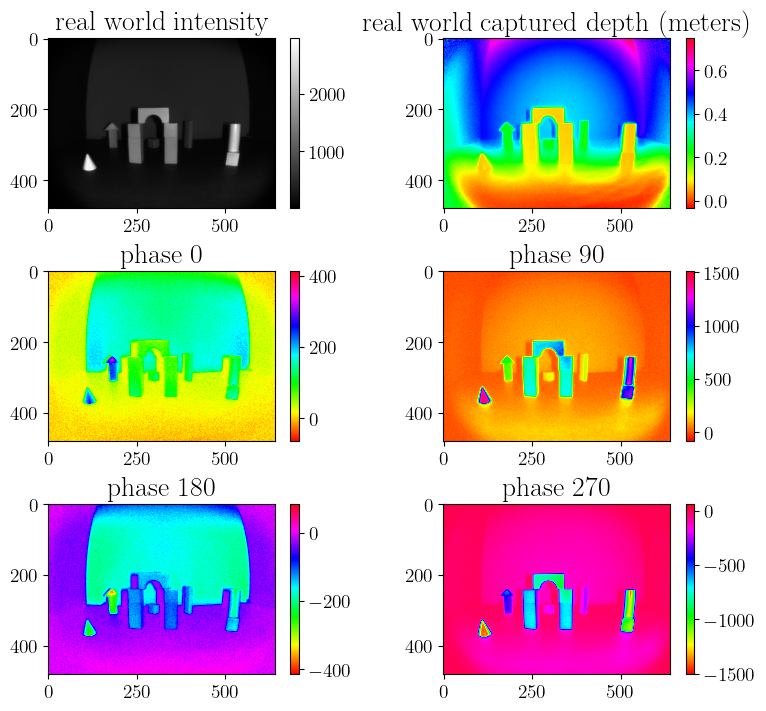

In [3]:
with np.load('data/emulation/dist_amp.npz') as gt_data:
    depth_rw = ((gt_data['dist'] - calib_offset) * 1e-3)[cropY:, cropX:] # divide by 1e3 to get meters
    intensity_rw = gt_data['amp'][cropY:, cropX:]
    
with np.load('data/emulation/phase_data.npz') as phase_data:
    I0_rw = phase_data['phase0'][cropY:, cropX:]
    I90_rw = phase_data['phase90'][cropY:, cropX:]
    I180_rw = phase_data['phase180'][cropY:, cropX:]
    I270_rw = phase_data['phase270'][cropY:, cropX:]

phase_rw = (depth_rw / coeff_to_rad) - pi # calculate the phase from the depth
rw_x, rw_y = intensity_rw.shape
quad_data_rw = [I0_rw, I90_rw, I180_rw, I270_rw]

# show the real world data
fig_rw, axs = plt.subplots(3,2, figsize=(8,7), layout="constrained")
im = axs[0,0].imshow(intensity_rw, cmap="gray")
axs[0,0].set_title("real world intensity")
fig_rw.colorbar(im, ax=axs[0,0])

im = axs[0,1].imshow(depth_rw, cmap="hsv")
axs[0,1].set_title("real world captured depth (meters)")
fig_rw.colorbar(im, ax=axs[0,1])

im = axs[1,0].imshow(I0_rw, cmap="hsv")
axs[1,0].set_title("phase 0")
fig_rw.colorbar(im, ax=axs[1,0])

im = axs[1,1].imshow(I90_rw, cmap="hsv")
axs[1,1].set_title("phase 90")
fig_rw.colorbar(im, ax=axs[1,1])

im = axs[2,0].imshow(I180_rw, cmap="hsv")
axs[2,0].set_title("phase 180")
fig_rw.colorbar(im, ax=axs[2,0])

im = axs[2,1].imshow(I270_rw, cmap="hsv")
axs[2,1].set_title("phase 270")
fig_rw.colorbar(im, ax=axs[2,1])

### Create a simulation with k=0

In [4]:
# create a simulation
k_deg_0 = 0
k_0 = np.deg2rad(k_deg_0)

fft_shift_sim_0 = fft_shift.FFT_Shift(k_0, 
                                    intensity_rw, depth_rw, 
                                    omega= 2 * pi * (mod_freq * 1e6))

# computationally create quad intensity measurements
fft_shift_sim_0.create_quad_intensity(method='mlx')

# compute emulated image intensity without prefilter
fft_shift_sim_0.create_composite_intensity(phase_variation_axis="x", use_Gaussian=None, method='mlx') # computational

composite_intensity_0 = fft_shift_sim_0.composite_image

# calculate the fft shift
fft_shift_sim_0.calculate_fft_shifted(phase_variation_axis="x")

# reconstruct and scale intensity, phase, depth from fft shift
recon_intensity_0 = 2 * fft_shift_sim_0.reconstruct_intensity()
recon_phase_0 = fft_shift_sim_0.reconstruct_phase() - (pi/2.0)
recon_depth_0 = ((c * (recon_phase_0 + pi)) / (4 * pi * mod_freq * 1e6))

### Create a simulation with k=4

In [5]:
# create a simulation
k_deg_4 = 360/4.0
k_4 = np.deg2rad(k_deg_4)

fft_shift_sim_4 = fft_shift.FFT_Shift(k_4, 
                                    intensity_rw, depth_rw, 
                                    omega= 2 * pi * (mod_freq * 1e6))

# computationally create quad intensity measurements
fft_shift_sim_4.create_quad_intensity(method='mlx')

# compute emulated image intensity without prefilter
fft_shift_sim_4.create_composite_intensity(phase_variation_axis="x", use_Gaussian=None, method='mlx') # computational

composite_intensity_4 = fft_shift_sim_4.composite_image

# calculate the fft shift
fft_shift_sim_4.calculate_fft_shifted(phase_variation_axis="x")

# reconstruct and scale intensity, phase, depth from fft shift
recon_intensity_4 = 2 * fft_shift_sim_4.reconstruct_intensity()
recon_phase_4 = fft_shift_sim_4.reconstruct_phase() - (pi/2.0)
recon_depth_4 = ((c * (recon_phase_4 + pi)) / (4 * pi * mod_freq * 1e6))

### Create a simulation with k=2

In [6]:
# create a simulation
k_deg_2 = 360/2.0
k_2 = np.deg2rad(k_deg_2)

fft_shift_sim_2 = fft_shift.FFT_Shift(k_2, 
                                    intensity_rw, depth_rw, 
                                    omega= 2 * pi * (mod_freq * 1e6))

# computationally create quad intensity measurements
fft_shift_sim_2.create_quad_intensity(method='mlx')
computed_phases = [fft_shift_sim_2.I0, fft_shift_sim_2.I90, fft_shift_sim_2.I180, fft_shift_sim_2.I270]

# compute emulated image intensity without prefilter
fft_shift_sim_2.create_composite_intensity(phase_variation_axis="x", use_Gaussian=None, method='mlx') # computational

composite_intensity_2 = fft_shift_sim_2.composite_image

# calculate the fft shift
fft_shift_sim_2.calculate_fft_shifted(phase_variation_axis="x")

# reconstruct and scale intensity, phase, depth from fft shift
recon_intensity_2 = 2 * fft_shift_sim_2.reconstruct_intensity()
recon_phase_2 = fft_shift_sim_2.reconstruct_phase() - (pi/2.0)
recon_depth_2 = ((c * (recon_phase_2 + pi)) / (4 * pi * mod_freq * 1e6))

### Create a simulation with k=11

In [7]:
# create a simulation
k_deg_11 = 360/11.0
k_11 = np.deg2rad(k_deg_11)

fft_shift_sim_11 = fft_shift.FFT_Shift(k_11, 
                                    intensity_rw, depth_rw, 
                                    omega= 2 * pi * (mod_freq * 1e6))

# computationally create quad intensity measurements
fft_shift_sim_11.create_quad_intensity(method='mlx')

# compute emulated image intensity without prefilter
fft_shift_sim_11.create_composite_intensity(phase_variation_axis="x", use_Gaussian=None, method='mlx') # computational

composite_intensity_11 = fft_shift_sim_11.composite_image

# calculate the fft shift
fft_shift_sim_11.calculate_fft_shifted(phase_variation_axis="x")

# reconstruct and scale intensity, phase, depth from fft shift
recon_intensity_11 = 2 * fft_shift_sim_11.reconstruct_intensity()
recon_phase_11 = fft_shift_sim_11.reconstruct_phase() - (pi/2.0)
recon_depth_11 = ((c * (recon_phase_11 + pi)) / (4 * pi * mod_freq * 1e6))

In [8]:
# print snr
snr_intensity_0 = calculate_snr(intensity_rw, recon_intensity_0)
snr_phase_0 = calculate_snr(phase_rw, recon_phase_0)

snr_intensity_4 = calculate_snr(intensity_rw, recon_intensity_4)
snr_phase_4 = calculate_snr(phase_rw, recon_phase_4)

snr_intensity_2 = calculate_snr(intensity_rw, recon_intensity_2)
snr_phase_2 = calculate_snr(phase_rw, recon_phase_2)

snr_intensity_11 = calculate_snr(intensity_rw, recon_intensity_11)
snr_phase_11 = calculate_snr(phase_rw, recon_phase_11)

print("SNR k=0: ", snr_intensity_0)
print("SNR k=0: ", snr_phase_0)
print("SNR k=2: ", snr_intensity_2)
print("SNR k=2: ", snr_phase_2)
print("SNR k=4: ", snr_intensity_4)
print("SNR k=4: ", snr_phase_4)
print("SNR k=11: ", snr_intensity_11)
print("SNR k=11 ", snr_phase_11)

SNR k=0:  -6.108275966469785
SNR k=0:  7.445678671910611
SNR k=2:  -6.833356355935159
SNR k=2:  7.607864651512003
SNR k=4:  25.113926035353934
SNR k=4:  35.83693343860952
SNR k=11:  10.400719027339642
SNR k=11  9.866906508470478


### Plot

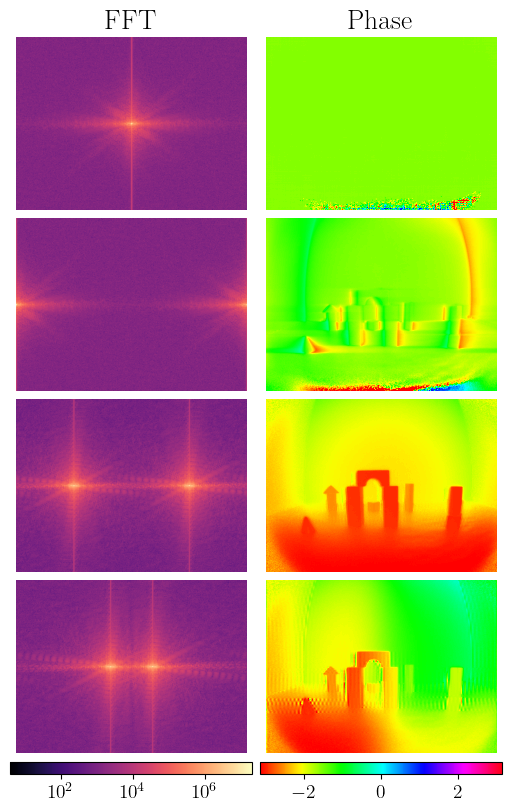

In [9]:
fig_recon, axs = plt.subplots(4,2, figsize=(5,8), layout="constrained")

img = axs[0,0].imshow(abs(fft_shift_sim_0.fft),norm=LogNorm(), cmap='magma')
axs[0,0].axis('off')
axs[0,0].set_title("FFT")

img = axs[0,1].imshow(recon_phase_0, cmap='hsv', vmin=-pi, vmax=pi)
axs[0,1].set_title("Phase")
axs[0,1].axis('off')

img = axs[1,0].imshow(abs(fft_shift_sim_2.fft),norm=LogNorm(), cmap='magma')
axs[1,0].axis('off')
img = axs[1,1].imshow(recon_phase_2, cmap='hsv', vmin=-pi, vmax=pi)
axs[1,1].axis('off')

img = axs[2,0].imshow(abs(fft_shift_sim_4.fft),norm=LogNorm(), cmap='magma')
axs[2,0].axis('off')
img = axs[2,1].imshow(recon_phase_4, cmap='hsv', vmin=-pi, vmax=pi)
axs[2,1].axis('off')

img = axs[3,0].imshow(abs(fft_shift_sim_11.fft),norm=LogNorm(), cmap='magma')
axs[3,0].axis('off')
fig_recon.colorbar(img, ax=axs[3,0], location='bottom')

img = axs[3,1].imshow(recon_phase_11, cmap='hsv', vmin=-pi, vmax=pi)
axs[3,1].axis('off')
fig_recon.colorbar(img, ax=axs[3,1], location='bottom')

if save_figs:
    fig_recon.savefig("figures/CVPRfigures/changing_k.pdf", bbox_inches = 'tight')


### Generate animation frames

In [17]:
num_ks = 51
lines = np.linspace(2, 12, num=num_ks) # number of lines it takes to span [0,360] deg
ks = np.deg2rad(np.repeat(360.0, num_ks) / lines) # in radians
print(lines)

for i in tqdm(range(num_ks)):
    crop = degrees2crop(np.rad2deg(ks[i]))
    # print("cropping {} lines".format(crop))

    fft_shift_sim = fft_shift.FFT_Shift(ks[i], 
                                    intensity_rw[:,crop:], depth_rw[:,crop:], 
                                    omega= 2 * pi * (mod_freq * 1e6))

    # computationally create quad intensity measurements
    fft_shift_sim.create_quad_intensity(method='mlx')

    # compute emulated image intensity without prefilter
    fft_shift_sim.create_composite_intensity(phase_variation_axis="x", use_Gaussian=None, method='mlx')

    composite_intensity = fft_shift_sim.composite_image

    # calculate the fft shift
    fft_shift_sim.calculate_fft_shifted(phase_variation_axis="x")

    # reconstruct and scale intensity, phase, depth from fft shift
    recon_intensity = 2 * fft_shift_sim.reconstruct_intensity()
    recon_phase = fft_shift_sim.reconstruct_phase() - (pi/2.0)
    recon_depth = ((c * (recon_phase + pi)) / (4 * pi * mod_freq * 1e6))

    fig_changing_k, axs = plt.subplots(2,2, figsize=(7,6), layout='constrained')
    fig_changing_k.suptitle("$k = 2\\pi$/{}".format(lines[i]))
    axs[0,0].imshow(composite_intensity, cmap='magma')
    axs[0,0].set_title("Snapshot")
    axs[0,1].imshow(recon_phase, cmap='hsv', vmin=-pi, vmax=pi)
    axs[0,1].set_title("Reconstructed Phase")
    axs[1,0].imshow(np.abs(fft_shift_sim.fft), cmap='magma', norm=LogNorm())
    axs[1,0].set_title("Snapshot FFT")
    axs[1,1].imshow(np.abs(fft_shift_sim.fft_centered), cmap='magma', norm=SymLogNorm(linthresh=1e1))
    axs[1,1].set_title("Snapshot FFT Centered")
    for a in axs.flatten():
        a.axis('off')

    if i<9:
        fig_changing_k.savefig("/Users/sarahfriday/Documents/changing_k_frames/frame0{}.png".format(i+1), bbox_inches='tight')
    else:
        fig_changing_k.savefig("/Users/sarahfriday/Documents/changing_k_frames/frame{}.png".format(i+1), bbox_inches='tight')

    plt.close()

[ 2.   2.2  2.4  2.6  2.8  3.   3.2  3.4  3.6  3.8  4.   4.2  4.4  4.6
  4.8  5.   5.2  5.4  5.6  5.8  6.   6.2  6.4  6.6  6.8  7.   7.2  7.4
  7.6  7.8  8.   8.2  8.4  8.6  8.8  9.   9.2  9.4  9.6  9.8 10.  10.2
 10.4 10.6 10.8 11.  11.2 11.4 11.6 11.8 12. ]


100%|███████████████████████████████████████████| 51/51 [00:15<00:00,  3.26it/s]


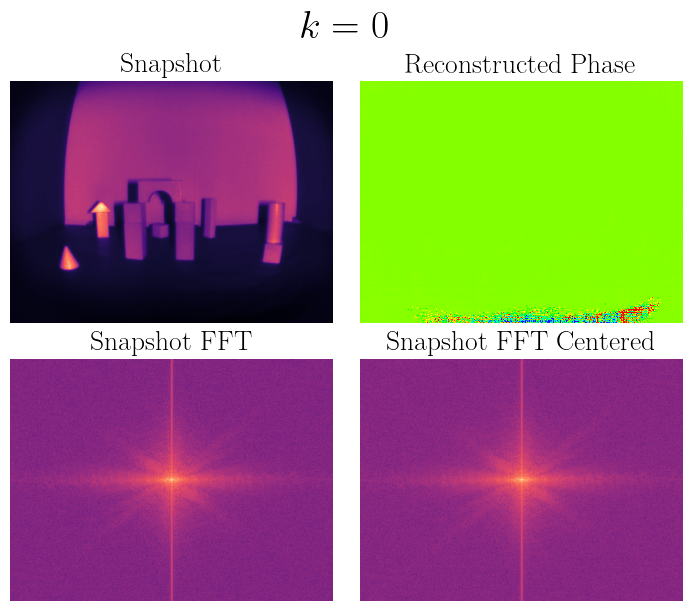

In [21]:
# create the k=0 frame

fft_shift_sim = fft_shift.FFT_Shift(0.0, 
                                    intensity_rw, depth_rw, 
                                    omega= 2 * pi * (mod_freq * 1e6))

# computationally create quad intensity measurements
fft_shift_sim.create_quad_intensity(method='mlx')

# compute emulated image intensity without prefilter
fft_shift_sim.create_composite_intensity(phase_variation_axis="x", use_Gaussian=None, method='mlx')

composite_intensity = fft_shift_sim.composite_image

# calculate the fft shift
fft_shift_sim.calculate_fft_shifted(phase_variation_axis="x")

# reconstruct and scale intensity, phase, depth from fft shift
recon_intensity = 2 * fft_shift_sim.reconstruct_intensity()
recon_phase = fft_shift_sim.reconstruct_phase() - (pi/2.0)
recon_depth = ((c * (recon_phase + pi)) / (4 * pi * mod_freq * 1e6))

fig_changing_k, axs = plt.subplots(2,2, figsize=(7,6), layout='constrained')
fig_changing_k.suptitle("$k = 0$")
axs[0,0].imshow(composite_intensity, cmap='magma')
axs[0,0].set_title("Snapshot")
axs[0,1].imshow(recon_phase, cmap='hsv', vmin=-pi, vmax=pi)
axs[0,1].set_title("Reconstructed Phase")
axs[1,0].imshow(np.abs(fft_shift_sim.fft), cmap='magma', norm=LogNorm())
axs[1,0].set_title("Snapshot FFT")
axs[1,1].imshow(np.abs(fft_shift_sim.fft_centered), cmap='magma', norm=SymLogNorm(linthresh=1e1))
axs[1,1].set_title("Snapshot FFT Centered")
for a in axs.flatten():
    a.axis('off')

fig_changing_k.savefig("/Users/sarahfriday/Documents/changing_k_frames/frame00.png", bbox_inches='tight')